In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # Gráficos
import seaborn as sns
import statsmodels.api as sm # forecast
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa as tsa

In [260]:
# importando a série histórica desde 1994
sh = pd.read_excel(r"C:\Users\Pohlmann\Documents\FGV\9º Semestre\Fin2\Trabalho 1 - Fin2.xlsx", sheet_name="SH", index_col=0)
sh.head()

,IBOV_PX_LAST,IBOV_Var,IBOV_Base100,SELIC_PX_LAST,SELIC_Daily Yield,SELIC_Base100
Date,,,,,,
2020-07-07,97761.0,-0.011888,2730.144102,2.15,0.000084,5887.391258
2020-07-06,98937.2,0.022449,2762.991510,2.15,0.000084,5886.894306
2020-07-03,96764.9,0.005506,2702.326296,2.15,0.000084,5886.397395
2020-07-02,96235.0,0.000331,2687.527927,2.15,0.000084,5885.900526
2020-07-01,96203.2,0.012071,2686.639857,2.15,0.000084,5885.403699


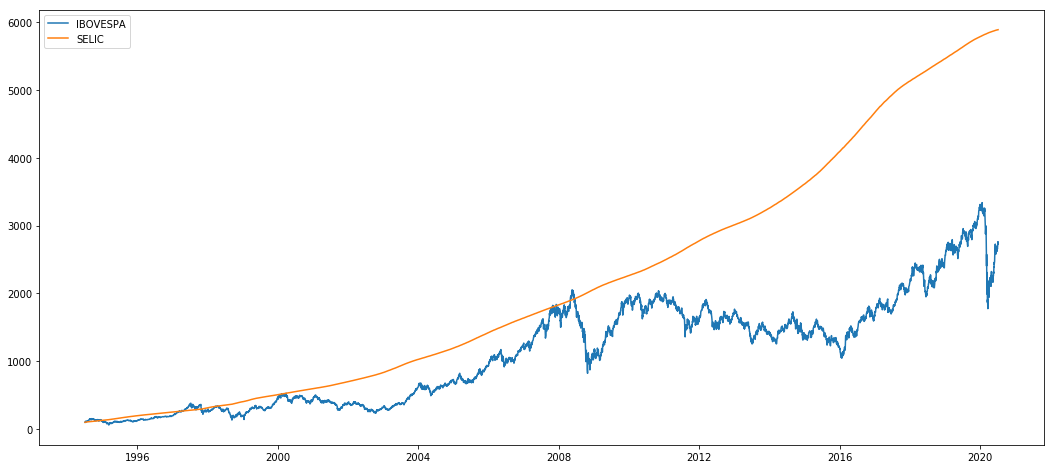

In [261]:
fig, ax = plt.subplots()
ax.plot(sh.IBOV_Base100, label="IBOVESPA")
ax.plot(sh.SELIC_Base100, label="SELIC")
leg = ax.legend()

Text(0.5,0.98,'Variações diárias')

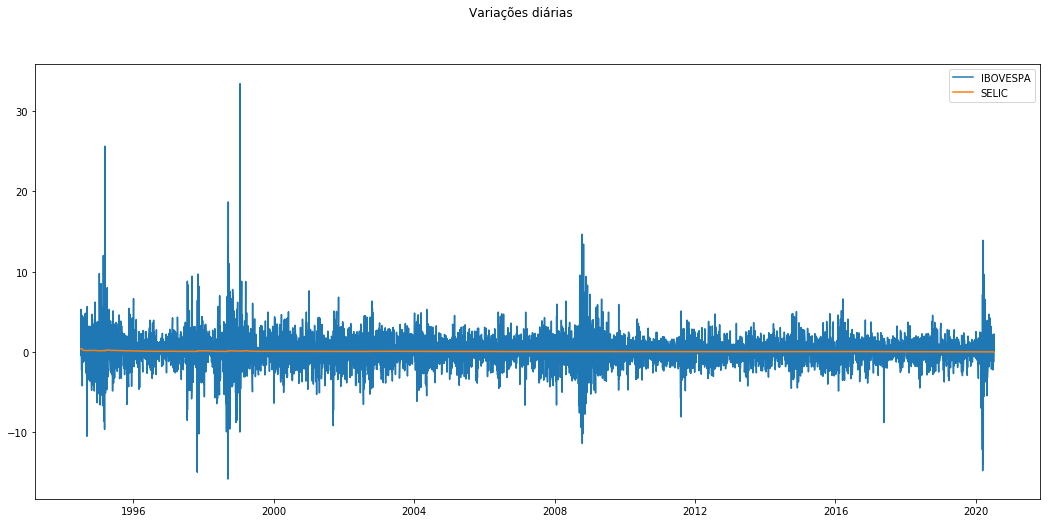

In [262]:
fig, ax = plt.subplots()
ax.plot(sh.IBOV_Var*100, label="IBOVESPA")
ax.plot(sh['SELIC_Daily Yield']*100, label="SELIC")
leg = ax.legend()
fig.suptitle("Variações diárias")

In [263]:
# importando a série histórica desde 2016
sh16 = pd.read_excel(r"C:\Users\Pohlmann\Documents\FGV\9º Semestre\Fin2\Trabalho 1 - Fin2.xlsx", sheet_name="SH16", index_col=0)
sh16.head()

,IBOV_PX_LAST,IBOV_Var,IBOV_Base100,SELIC_PX_LAST,SELIC_Daily Yield,SELIC_Base100
Date,,,,,,
2020-07-07,97761.0,-0.011888,231.985477,2.15,0.000084,143.826120
2020-07-06,98937.2,0.022449,234.776583,2.15,0.000084,143.813980
2020-07-03,96764.9,0.005506,229.621746,2.15,0.000084,143.801841
2020-07-02,96235.0,0.000331,228.364301,2.15,0.000084,143.789703
2020-07-01,96203.2,0.012071,228.288840,2.15,0.000084,143.777565


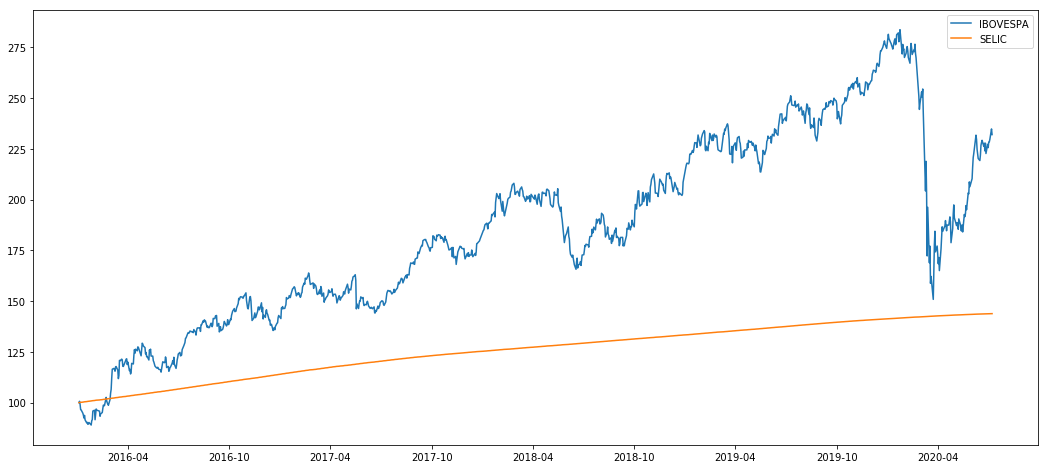

In [265]:
fig, ax = plt.subplots()
ax.plot(sh16.IBOV_Base100, label="IBOVESPA")
ax.plot(sh16.SELIC_Base100, label="SELIC")
leg = ax.legend()

### Forecast

In [248]:
a = sh.IBOV_Base100.sort_index().asfreq("d", method='ffill')

In [146]:
b = sh.SELIC_Base100.sort_index().asfreq("w", method='ffill')

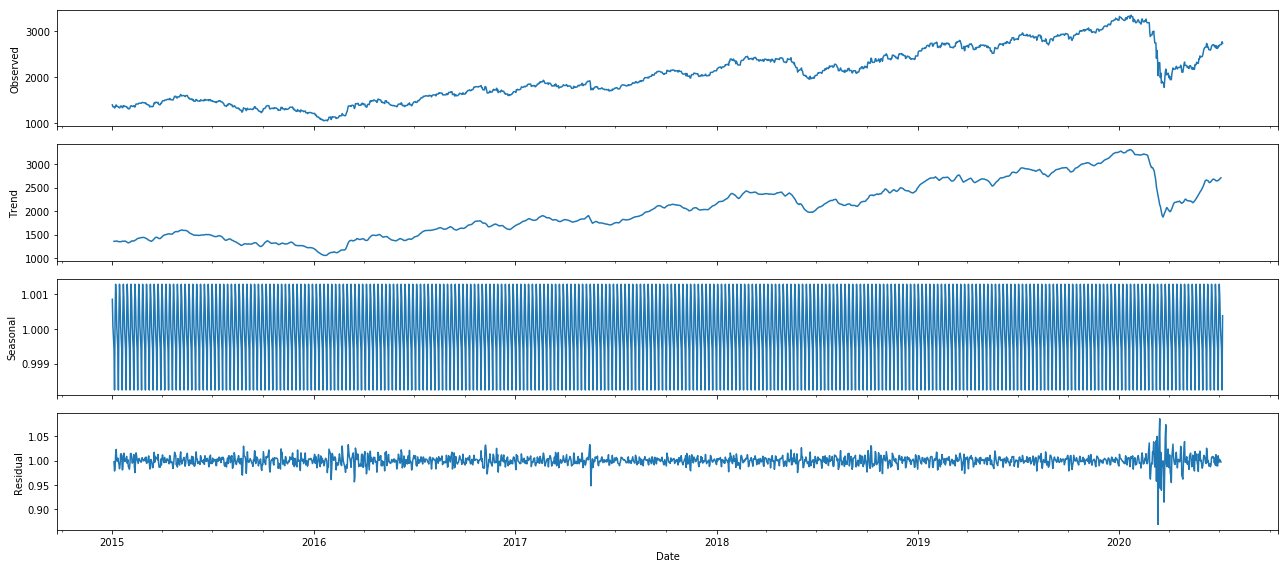

In [249]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(a['2015':], model='multiplicative')
fig = decomposition.plot()
plt.show()

In [258]:
# fit model
model = SARIMAX(a, order=(1, 1, 1), seasonal_order=(1, 1, 1, 90))
model_fit = model.fit(disp=False)
# fit summary
print(model_fit.summary().tables[1])

KeyboardInterrupt: 

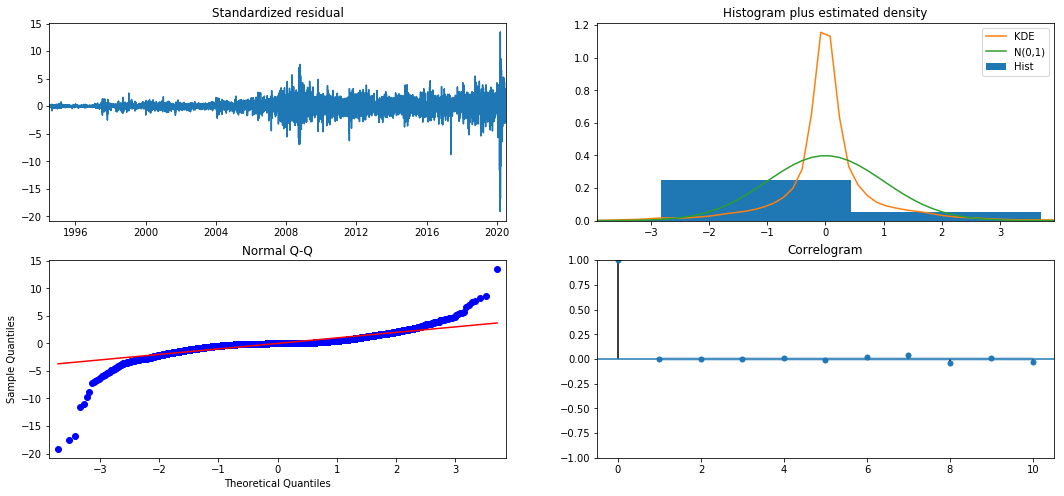

In [251]:
model_fit.plot_diagnostics(figsize=(18, 8))
plt.show()

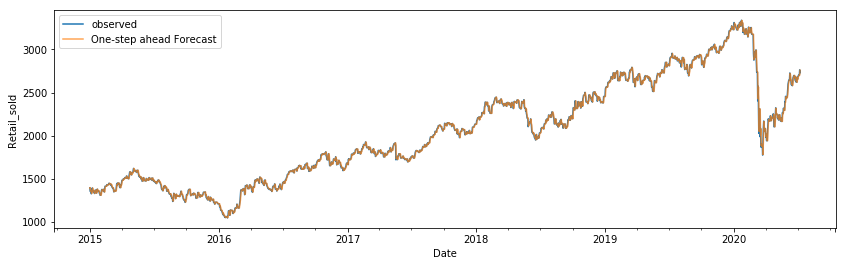

In [252]:
pred = model_fit.get_prediction(dynamic=False)
pred_ci = pred.conf_int()
ax = a['2015':].plot(label='observed')
pred.predicted_mean['2015':].plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()

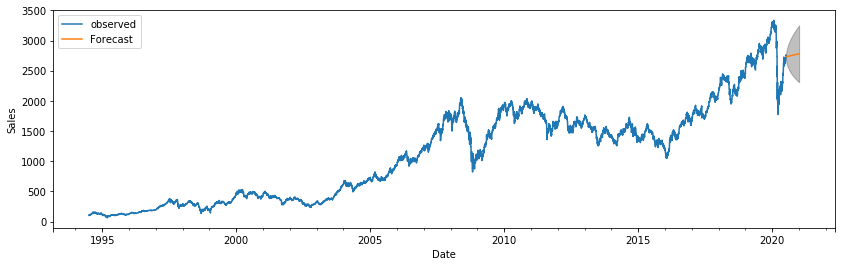

In [254]:
pred_uc = model_fit.get_forecast(steps=180)
pred_ci = pred_uc.conf_int(alpha=0.05)
ax = a.plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [230]:
pred_uc = model_fit.get_forecast(steps=30)

In [247]:
pred_uc.predicted_mean.head(5)

2020-07-12    2699.565410
2020-07-19    2709.675085
2020-07-26    2712.556741
2020-08-02    2715.066681
2020-08-09    2718.011232
Freq: W-SUN, dtype: float64

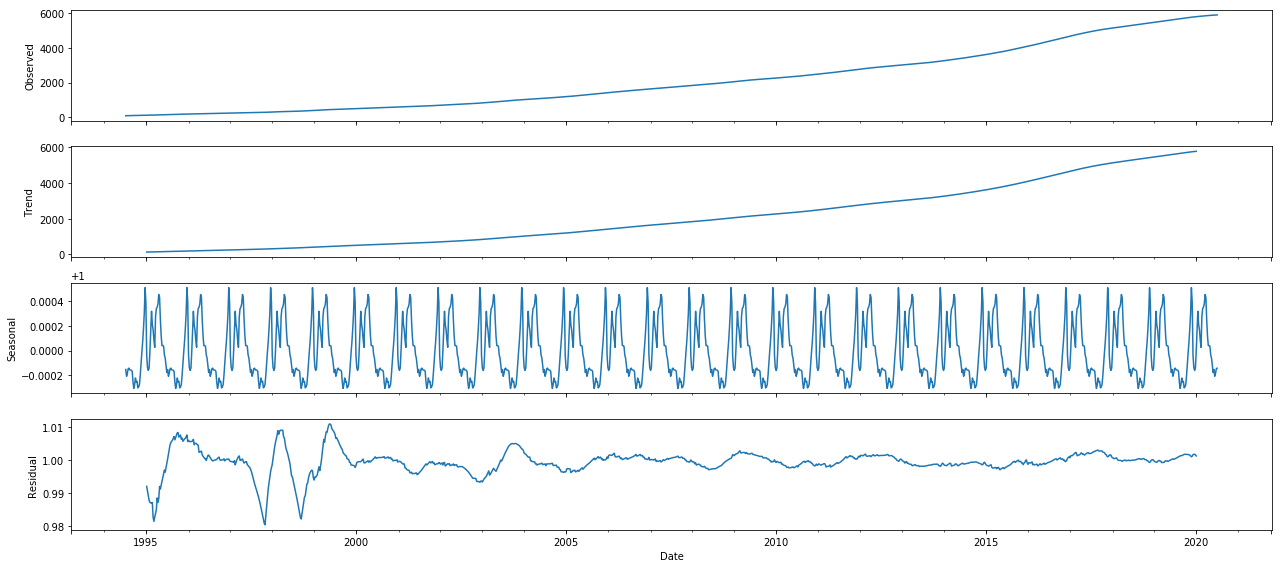

In [147]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(b, model='multiplicative')
fig = decomposition.plot()
plt.show()